In [1]:
import pandas as pd
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import mannwhitneyu

In [2]:
default_colors = {
    "indigo": "#332288",
    "cyan": "#88CCEE",
    "teal": "#44AA99",
    "green": "#117733",
    "olive": "#999933",
    "sand": "#DDCC77",
    "rose": "#CC6677",
    "wine": "#882255",
    "purple": "#AA4499",
    "grey": "#DDDDDD",
}

eval_setting_map = {
    "identity": default_colors["wine"],
    "CAROT": default_colors["cyan"],
    "conCAROT": default_colors["indigo"],
    "within condition": default_colors["green"],
    "chemCPA": default_colors["sand"],
    "avg CAR": default_colors["rose"]
}

geneset_map = {
    "functional": default_colors["olive"],
    "functional+score": default_colors["rose"],
    "HVG": default_colors["teal"],
    "random": default_colors["sand"],
}

subset_map = {
    "CD4": default_colors["teal"],
    "CD8": default_colors["purple"],
}

ot_map = {
    "source": default_colors["cyan"],
    "target": default_colors["sand"],
    "transport": default_colors["rose"],
    "rest": default_colors["grey"]
}
sel_cars = ['CD40-CD40-z', "IL15RA-CD40-z", "CD28-CTLA4-z"]
sc_palette = {'CD40-CD40-z': default_colors["sand"],
             "IL15RA-CD40-z": default_colors["cyan"],
             "CD28-CTLA4-z": default_colors["rose"]}
sc_markers = {'CD40-CD40-z': "s",
             "IL15RA-CD40-z": "^",
             "CD28-CTLA4-z": "X"}

In [3]:
sns.set(font="Arial")
sns.set_context("paper")
sns.set_style("whitegrid")
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['ytick.left'] = True
mpl.rcParams['xtick.bottom'] = True

In [4]:
base_fig_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Figures/cmonge/"

# Compare CAR embeddings - Appendix (trained on all CARs)

In [6]:
exp_order = ["conCAROT", "identity"] + ["within condition"]*32

all_mean_metrics = []
for subset in ["CD4", "CD8"]:
    for embedding in ["11d", "16d", "metadata", "esm_small_tail_dim", "esm_XL_tail_dim"]:
        with open(f"/path/to/experiments/cmonge/LN_True_grad_acc_4_cosine/{subset}_{embedding}_FuncScore/logs.yaml") as stream:
            logs = yaml.safe_load(stream)
        if len(logs["experiments"])==68:
            print("using only the first 34 logs")
            logs["experiments"]=logs["experiments"][:34]
        print(subset, embedding, len(logs["experiments"]))
        
        for i in range(len(logs["experiments"])):
            eval_setting = exp_order[i]
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["embedding"] = embedding
                res["eval_car"] = condition
                res["eval_setting"] = eval_setting
                res["subset"] = subset
                all_mean_metrics.append(res)

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/experiments/cmonge/LN_True_grad_acc_4_cosine/CD4_11d_FuncScore/logs.yaml'

In [7]:
res = pd.concat(all_mean_metrics).reset_index(drop=True)
res = res[~res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
res.loc[res["embedding"]=="esm_large_tail_dim", "embedding"] = "ESM large"
res.loc[res["embedding"]=="esm_XL_tail_dim", "embedding"] = "ESM XL"
res.loc[res["embedding"]=="esm_small_tail_dim", "embedding"] = "ESM small"
res

ValueError: No objects to concatenate

In [8]:
default_colors

{'indigo': '#332288',
 'cyan': '#88CCEE',
 'teal': '#44AA99',
 'green': '#117733',
 'olive': '#999933',
 'sand': '#DDCC77',
 'rose': '#CC6677',
 'wine': '#882255',
 'purple': '#AA4499',
 'grey': '#DDDDDD'}

In [8]:
embedding_map = {"11d": default_colors["teal"],
                "16d": default_colors["cyan"],
                "metadata": default_colors["purple"],
                "ESM small": default_colors["sand"],
                "ESM XL": default_colors["green"]}

In [9]:
res = res[res["embedding"]!="ESM large"]

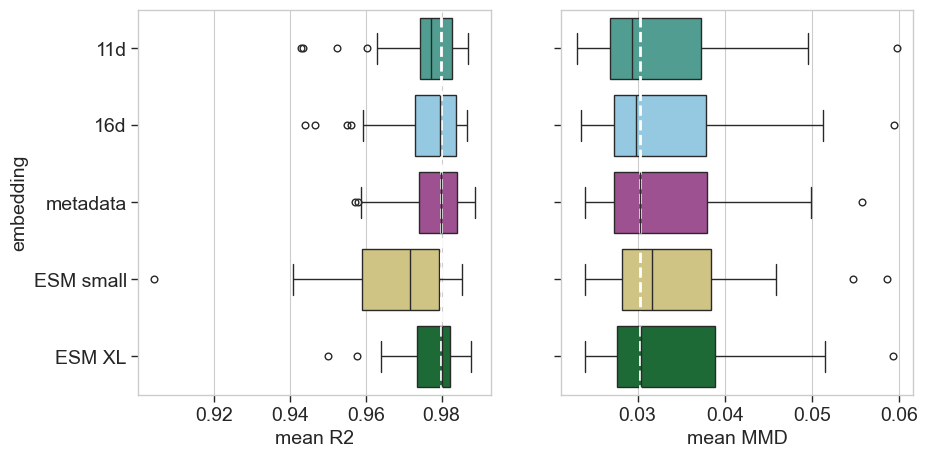

In [10]:
fig, axes = plt.subplots(1,2,sharey=True, figsize=(10, 5))

plt_data = res[(res["eval_setting"]=="conCAROT")&(res["metric"]=="mean_r2")&(res["subset"]=="CD8")]
sns.boxplot(data=plt_data, x="score", y="embedding", hue="embedding", ax=axes[0],
           palette=embedding_map, order=embedding_map.keys())
axes[0].set_ylabel("embedding", fontsize=14)
axes[0].set_xlabel("mean $R^2$", fontsize=14)
axes[0].tick_params(which="both", axis="both", labelsize=14)
axes[0].axvline(x=plt_data.loc[plt_data["embedding"]=="metadata", 'score'].median(),
               linestyle="--", color="white", linewidth=2)

plt_data = res[(res["eval_setting"]=="conCAROT")&(res["metric"]=="mean_mmd")]
sns.boxplot(data=plt_data, x="score", y="embedding",  hue="embedding", ax=axes[1],
           palette=embedding_map, order=embedding_map.keys())
axes[1].set_ylabel("embedding", fontsize=14)
axes[1].set_xlabel("mean MMD", fontsize=14)
axes[1].tick_params(which="both", axis="both", labelsize=14)
axes[1].axvline(x=plt_data.loc[plt_data["embedding"]=="metadata", 'score'].median(),
                linestyle="--", color="white", linewidth=2)
plt.savefig(f"{base_fig_dir}embedding_comparison.pdf", bbox_inches="tight")

# conCAROT - ID - TRAINED ON ALL CARS

In [11]:
sel_res = res[res["embedding"]=="ESM XL"]

In [12]:
pvals = []
metrics = []
subsets = []
comparisons = []
for metric in ["mean_mmd", "mean_r2"]:
    for subset in ["CD8", "CD4"]:
        for comparison in [("conCAROT", "identity"), ("conCAROT", "within condition")]:
            stats_res = sel_res[(sel_res["metric"]==metric)&(sel_res["subset"]==subset)]

            pval = mannwhitneyu(stats_res.loc[stats_res["eval_setting"]==comparison[0], "score"], 
                                stats_res.loc[stats_res["eval_setting"]==comparison[1], 'score'],
                                ).pvalue 
            pvals.append(pval)
            metrics.append(metric)
            subsets.append(subset)
            comparisons.append(comparison)
stats = pd.DataFrame({"pval": pvals, "subset": subsets, "metric": metrics})
stats[["setting1", "setting2"]] = comparisons
stats["corr_pval"] = stats["pval"] *len(stats)
stats["treshold"] = 0.05/len(stats)
stats["significant1"] =  stats["pval"] < stats["treshold"]
stats["significant2"] =  stats["corr_pval"] < 0.05
stats

,pval,subset,metric,setting1,setting2,corr_pval,treshold,significant1,significant2
0,7.772550e-09,CD8,mean_mmd,conCAROT,identity,6.218040e-08,0.00625,True,True
1,4.638966e-05,CD8,mean_mmd,conCAROT,within condition,3.711173e-04,0.00625,True,True
2,1.491804e-06,CD4,mean_mmd,conCAROT,identity,1.193443e-05,0.00625,True,True
3,3.368140e-05,CD4,mean_mmd,conCAROT,within condition,2.694512e-04,0.00625,True,True
4,3.019859e-11,CD8,mean_r2,conCAROT,identity,2.415887e-10,0.00625,True,True
5,9.587315e-01,CD8,mean_r2,conCAROT,within condition,7.669852e+00,0.00625,False,False
6,3.019859e-11,CD4,mean_r2,conCAROT,identity,2.415887e-10,0.00625,True,True
7,3.513660e-02,CD4,mean_r2,conCAROT,within condition,2.810928e-01,0.00625,False,False


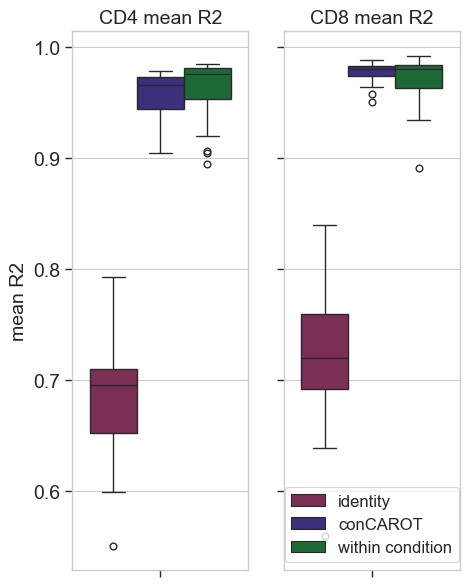

In [13]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = sel_res[(sel_res["subset"]==subset)&(sel_res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "conCAROT", "within condition"])
    axes[i].set_title(f"{subset} mean $R^2$", fontsize=14)
    axes[i].set_ylabel("mean $R^2$", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)

    
axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_dir}R2_performance.pdf", bbox_inches="tight")

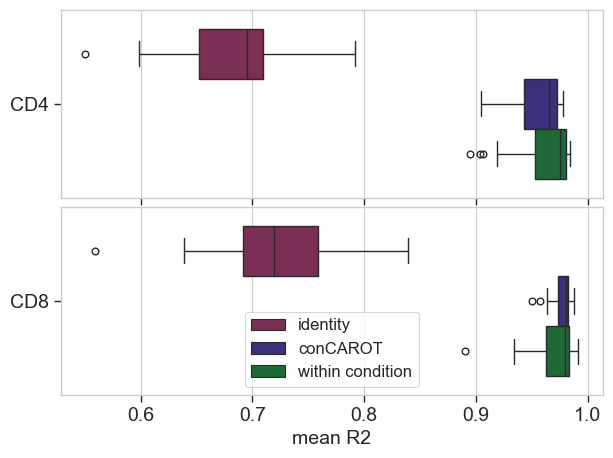

In [14]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,5))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = sel_res[(sel_res["subset"]==subset)&(sel_res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, x="score", y="subset", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "conCAROT", "within condition"])
    axes[i].set_ylabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

    
axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
axes[1].set_xlabel("mean $R^2$", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.subplots_adjust(wspace=None, hspace=0.05)
plt.savefig(f"{base_fig_dir}R2_performance_horizontal.pdf", bbox_inches="tight")

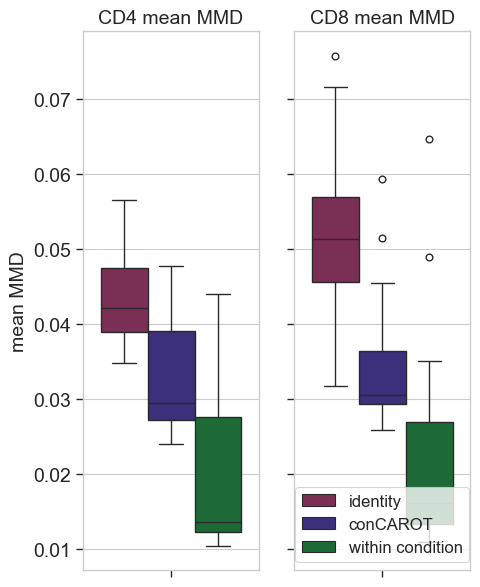

In [15]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = sel_res[(sel_res["subset"]==subset)&(sel_res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "conCAROT", "within condition"])
    axes[i].set_title(f"{subset} mean MMD", fontsize=14)
    axes[i].set_ylabel("mean MMD", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)

axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_dir}MMD_performance.pdf", bbox_inches="tight")

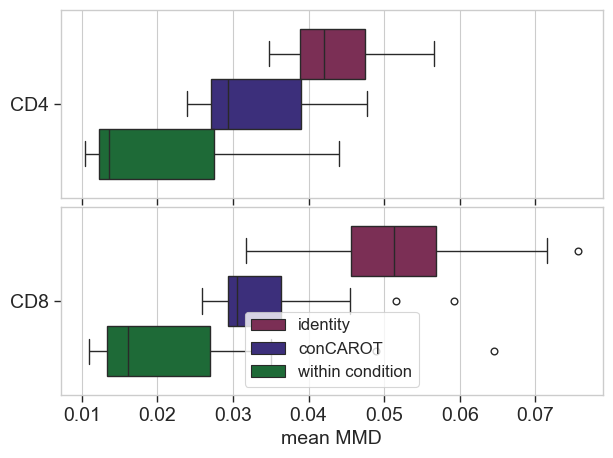

In [16]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,5))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = sel_res[(sel_res["subset"]==subset)&(sel_res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, x="score", y="subset", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "conCAROT", "within condition"])
    axes[i].set_ylabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

    
axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
axes[1].set_xlabel("mean MMD", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.subplots_adjust(wspace=None, hspace=0.05)
plt.savefig(f"{base_fig_dir}MMD_performance_horizontal.pdf", bbox_inches="tight")

### Scores per CAR

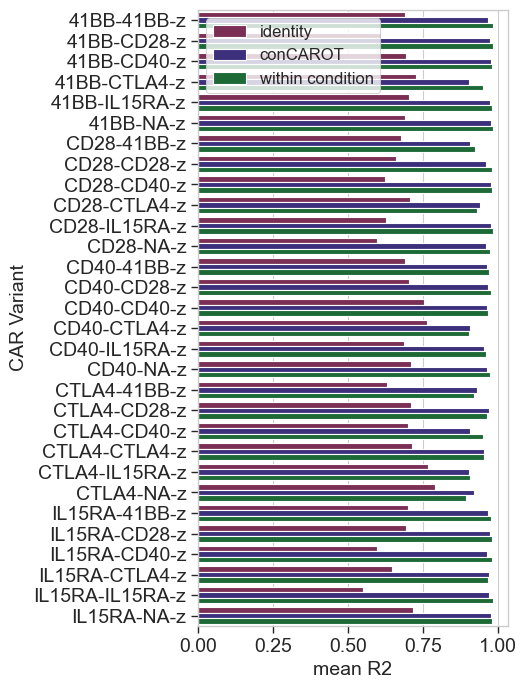

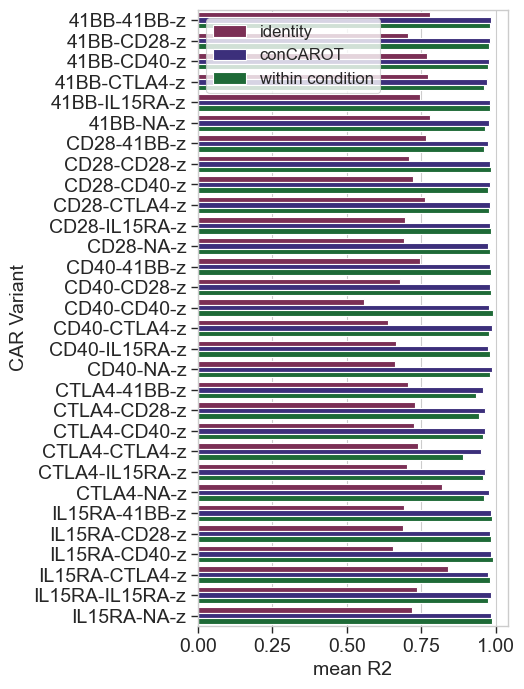

In [17]:
for subset in ["CD4", "CD8"]:
    plt_data = sel_res[(sel_res["metric"]=="mean_r2")&(sel_res["subset"]==subset)]
    plt.figure(figsize=(4,8))
    sns.barplot(data=plt_data, x="score", y="eval_car", hue="eval_setting", palette=eval_setting_map, 
                hue_order=["identity", "conCAROT", "within condition"])
    plt.ylabel("CAR Variant", fontsize=14)
    plt.xlabel("mean $R^2$", fontsize=14)
    plt.tick_params(which="both", axis="both", labelsize=14)
    plt.legend(loc="upper left", title="", fontsize=12)
    plt.savefig(f"{base_fig_dir}R2_per_car_{subset}.pdf", bbox_inches="tight")
    plt.show()

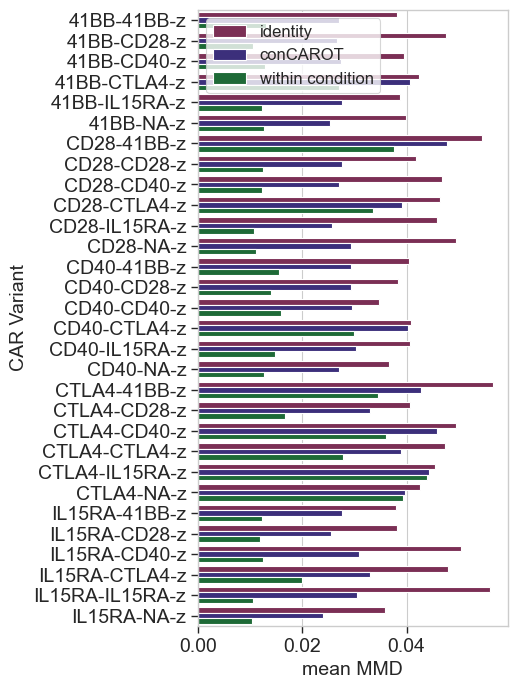

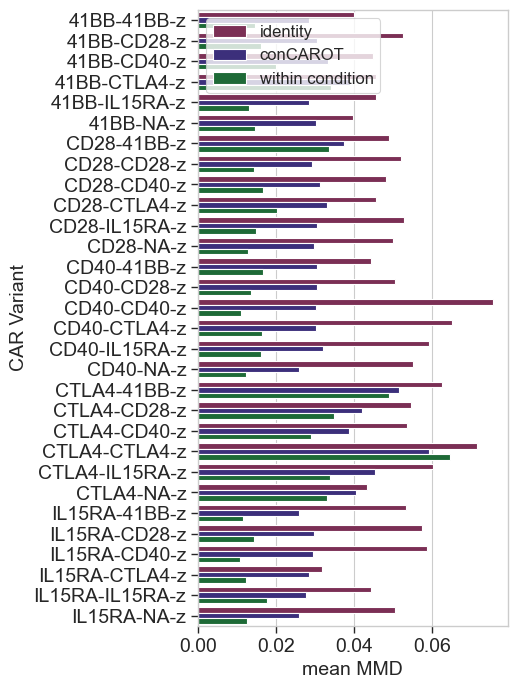

In [18]:
for subset in ["CD4", "CD8"]:
    plt_data = sel_res[(sel_res["metric"]=="mean_mmd")&(sel_res["subset"]==subset)]
    plt.figure(figsize=(4,8))
    sns.barplot(data=plt_data, x="score", y="eval_car", hue="eval_setting", palette=eval_setting_map, 
                hue_order=["identity", "conCAROT", "within condition"])
    plt.ylabel("CAR Variant", fontsize=14)
    plt.xlabel("mean MMD", fontsize=14)
    plt.tick_params(which="both", axis="both", labelsize=14)
    plt.legend(loc="upper left", title="", fontsize=12)
    plt.savefig(f"{base_fig_dir}MMD_per_car_{subset}.pdf", bbox_inches="tight")
    plt.show()

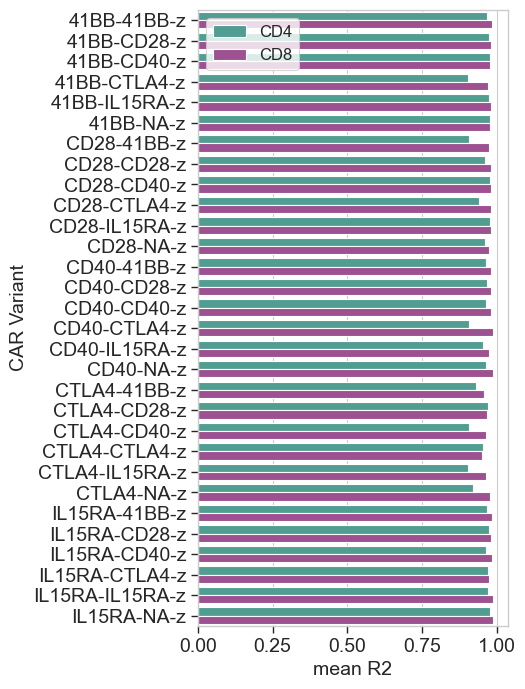

In [19]:
plt_data = sel_res[(sel_res["metric"]=="mean_r2")&(sel_res["eval_setting"]=="conCAROT")]
plt.figure(figsize=(4,8))
sns.barplot(data=plt_data, x="score", y="eval_car", hue="subset", palette=subset_map)
plt.ylabel("CAR Variant", fontsize=14)
plt.xlabel("mean $R^2$", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.legend(loc="upper left", title="", fontsize=12)
plt.savefig(f"{base_fig_dir}R2_per_car.pdf", bbox_inches="tight")
plt.show()

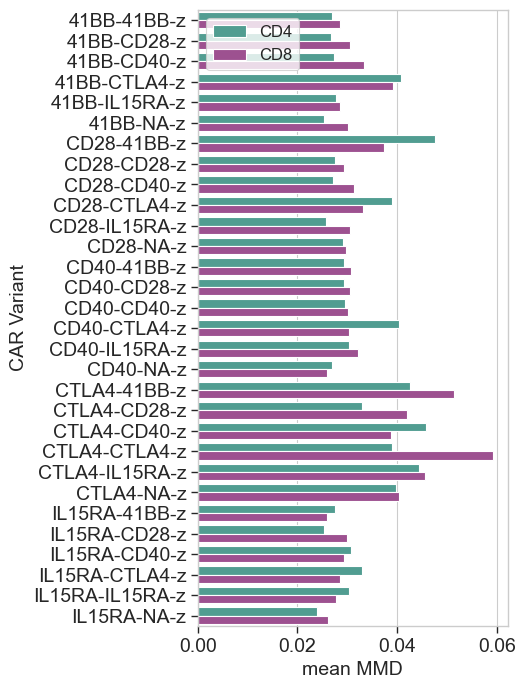

In [20]:
plt_data = sel_res[(sel_res["metric"]=="mean_mmd")&(sel_res["eval_setting"]=="conCAROT")]
plt.figure(figsize=(4,8))
sns.barplot(data=plt_data, x="score", y="eval_car", hue="subset", palette=subset_map)
plt.ylabel("CAR Variant", fontsize=14)
plt.xlabel("mean MMD", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.legend(loc="upper left", title="", fontsize=12)
plt.savefig(f"{base_fig_dir}MMD_per_car.pdf", bbox_inches="tight")
plt.show()

# conCAROT - ID - TRAINED ON CARS WITH >750 CELLS (FIG. 4)

In [5]:
exp_order = ["conCAROT", "identity"] + ["within condition"]*32

all_mean_metrics = []
all_single_scores = []
for subset in ["CD4", "CD8"]:
    for embedding in ["esm_XL_tail_dim"]:
        with open(f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/{subset}_{embedding}_FuncScore/logs.yaml") as stream:
            logs = yaml.safe_load(stream)
        print(subset, embedding, len(logs["experiments"]))
        
        for i in range(len(logs["experiments"])):
            eval_setting = exp_order[i]
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["embedding"] = embedding
                res["eval_car"] = condition
                res["eval_setting"] = eval_setting
                res["subset"] = subset
                all_mean_metrics.append(res)

                single_scores = pd.DataFrame({"r2": results["r2"], "mmd": results["mmd"]})
                single_scores["embedding"] = embedding
                single_scores["eval_car"] = condition
                single_scores["eval_setting"] = eval_setting
                single_scores["subset"] = subset
                all_single_scores.append(single_scores)

CD4 esm_XL_tail_dim 18
CD8 esm_XL_tail_dim 16


In [6]:
res = pd.concat(all_mean_metrics).reset_index(drop=True)
res = res[~res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
res.loc[res["embedding"]=="esm_XL_tail_dim", "embedding"] = "ESM XL"

single_scores_res = pd.concat(all_single_scores).reset_index(drop=True)
single_scores_res = single_scores_res[~single_scores_res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
single_scores_res.loc[single_scores_res["embedding"]=="esm_XL_tail_dim", "embedding"] = "ESM XL"

In [7]:
# avgerage CAR model
all_mean_metrics = []
all_single_scores = []

for subset in ["CD4", "CD8"]:
    with open(f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge_ood/sel_CARs_ood/model_sel_cars_{subset}_avg_CAR_ID_CARs_eval.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
    for i in range(len(logs["experiments"])):
        for condition, results in logs["experiments"][i]["valid-set"].items():
            result = pd.Series(results["mean_statistics"])
            result = result.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
            result["eval_car"] = condition
            result["eval_setting"] = "avg CAR"
            result["subset"] = subset
            result["embedding"] = "ESM XL"
            all_mean_metrics.append(result)

            single_scores = pd.DataFrame({"r2": results["r2"], "mmd": results["mmd"]})
            single_scores["embedding"] = "ESM XL"
            single_scores["eval_car"] = condition
            single_scores["eval_setting"] = "avg CAR"
            single_scores["subset"] = subset
            all_single_scores.append(single_scores)
avg_CAR_res = pd.concat(all_mean_metrics).reset_index(drop=True)
avg_CAR_res = avg_CAR_res[~avg_CAR_res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
avg_CAR_single_scores = pd.concat(all_single_scores).reset_index(drop=True)
avg_CAR_single_scores = avg_CAR_single_scores[~avg_CAR_single_scores["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
avg_CAR_res

,metric,score,eval_car,eval_setting,subset,embedding
0,mean_wasserstein,6.111590,CD28-IL15RA-z,avg CAR,CD4,ESM XL
1,mean_mmd,0.011681,CD28-IL15RA-z,avg CAR,CD4,ESM XL
2,mean_sinkhorn div,5.596750,CD28-IL15RA-z,avg CAR,CD4,ESM XL
3,mean_monge_gap,11.586283,CD28-IL15RA-z,avg CAR,CD4,ESM XL
4,mean_drug_signature,0.936983,CD28-IL15RA-z,avg CAR,CD4,ESM XL
...,...,...,...,...,...,...
175,mean_mmd,0.016477,41BB-41BB-z,avg CAR,CD8,ESM XL
176,mean_sinkhorn div,6.315613,41BB-41BB-z,avg CAR,CD8,ESM XL
177,mean_monge_gap,12.116000,41BB-41BB-z,avg CAR,CD8,ESM XL
178,mean_drug_signature,1.274037,41BB-41BB-z,avg CAR,CD8,ESM XL


In [8]:
avg_CAR_res[["eval_car", "subset"]].drop_duplicates().groupby("subset").size()

subset
CD4    16
CD8    14
dtype: int64

In [9]:
# chemCPA results
chemcpa = pd.read_csv("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/chemCPA/ID_CD4_CD8_carot_results.csv", index_col=0)
chemcpa_single_scores = pd.read_csv("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/chemCPA/ID_CD4_CD8_carot_single_scores.csv", index_col=0)
chemcpa = chemcpa[~chemcpa["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
chemcpa_single_scores = chemcpa_single_scores[~chemcpa_single_scores["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]

res = pd.concat([res, chemcpa, avg_CAR_res]).reset_index(drop=True)
single_scores = pd.concat([single_scores_res, avg_CAR_single_scores, chemcpa_single_scores])
res

,metric,score,embedding,eval_car,eval_setting,subset
0,mean_wasserstein,5.533756,ESM XL,CD28-IL15RA-z,conCAROT,CD4
1,mean_mmd,0.026047,ESM XL,CD28-IL15RA-z,conCAROT,CD4
2,mean_sinkhorn div,5.047623,ESM XL,CD28-IL15RA-z,conCAROT,CD4
3,mean_monge_gap,11.387654,ESM XL,CD28-IL15RA-z,conCAROT,CD4
4,mean_drug_signature,0.756655,ESM XL,CD28-IL15RA-z,conCAROT,CD4
...,...,...,...,...,...,...
895,mean_mmd,0.016477,ESM XL,41BB-41BB-z,avg CAR,CD8
896,mean_sinkhorn div,6.315613,ESM XL,41BB-41BB-z,avg CAR,CD8
897,mean_monge_gap,12.116000,ESM XL,41BB-41BB-z,avg CAR,CD8
898,mean_drug_signature,1.274037,ESM XL,41BB-41BB-z,avg CAR,CD8


In [10]:
single_scores

,r2,mmd,embedding,eval_car,eval_setting,subset
0,0.978494,0.025670,ESM XL,CD28-IL15RA-z,conCAROT,CD4
1,0.975694,0.025554,ESM XL,CD28-IL15RA-z,conCAROT,CD4
2,0.982802,0.027720,ESM XL,CD28-IL15RA-z,conCAROT,CD4
3,0.983691,0.025058,ESM XL,CD28-IL15RA-z,conCAROT,CD4
4,0.978484,0.026084,ESM XL,CD28-IL15RA-z,conCAROT,CD4
...,...,...,...,...,...,...
6,0.981416,0.179163,ESM XL,IL15RA-NA-z,chemCPA,CD8
7,0.981580,0.175184,ESM XL,IL15RA-NA-z,chemCPA,CD8
8,0.981166,0.176427,ESM XL,IL15RA-NA-z,chemCPA,CD8
9,0.976045,0.177624,ESM XL,IL15RA-NA-z,chemCPA,CD8


In [11]:
res.groupby(["eval_setting", "subset"]).size()

eval_setting      subset
avg CAR           CD4       96
                  CD8       84
chemCPA           CD4       96
                  CD8       84
conCAROT          CD4       96
                  CD8       84
identity          CD4       96
                  CD8       84
within condition  CD4       96
                  CD8       84
dtype: int64

In [12]:
single_scores.groupby(["eval_setting", "subset"]).size()

eval_setting      subset
avg CAR           CD4       176
                  CD8       154
chemCPA           CD4       176
                  CD8       154
conCAROT          CD4       176
                  CD8       154
identity          CD4       176
                  CD8       154
within condition  CD4       176
                  CD8       154
dtype: int64

In [13]:
pvals = []
metrics = []
subsets = []
comparisons = []
for metric in ["mean_mmd", "mean_r2"]:
    for subset in ["CD8", "CD4"]:
        for comparison in [("conCAROT", "identity"), ("conCAROT", "within condition"), 
                           ("conCAROT", "chemCPA"), ("chemCPA", "within condition"), ("chemCPA", "identity"),
                           ("conCAROT", "avg CAR"), ("chemCPA", "avg CAR")]:
            # print(comparison)
            stats_res = res[(res["metric"]==metric)&(res["subset"]==subset)]

            pval = mannwhitneyu(stats_res.loc[stats_res["eval_setting"]==comparison[0], "score"], 
                                stats_res.loc[stats_res["eval_setting"]==comparison[1], 'score'],
                                ).pvalue 
            pvals.append(pval)
            metrics.append(metric)
            subsets.append(subset)
            comparisons.append(comparison)
stats = pd.DataFrame({"pval": pvals, "subset": subsets, "metric": metrics})
stats[["setting1", "setting2"]] = comparisons
stats["corr_pval"] = stats["pval"] *len(stats)
stats["treshold"] = 0.05/len(stats)
stats["significant1"] =  stats["pval"] < stats["treshold"]
stats["significant2"] =  stats["corr_pval"] < 0.05
stats

,pval,subset,metric,setting1,setting2,corr_pval,treshold,significant1,significant2
0,0.000007,CD8,mean_mmd,conCAROT,identity,0.000209,0.001786,True,True
1,0.000007,CD8,mean_mmd,conCAROT,within condition,0.000209,0.001786,True,True
2,0.000007,CD8,mean_mmd,conCAROT,chemCPA,0.000209,0.001786,True,True
3,0.000007,CD8,mean_mmd,chemCPA,within condition,0.000209,0.001786,True,True
4,0.000007,CD8,mean_mmd,chemCPA,identity,0.000209,0.001786,True,True
5,0.000732,CD8,mean_mmd,conCAROT,avg CAR,0.020507,0.001786,True,True
6,0.000007,CD8,mean_mmd,chemCPA,avg CAR,0.000209,0.001786,True,True
7,0.000002,CD4,mean_mmd,conCAROT,identity,0.000043,0.001786,True,True
8,0.000002,CD4,mean_mmd,conCAROT,within condition,0.000043,0.001786,True,True
9,0.000002,CD4,mean_mmd,conCAROT,chemCPA,0.000043,0.001786,True,True


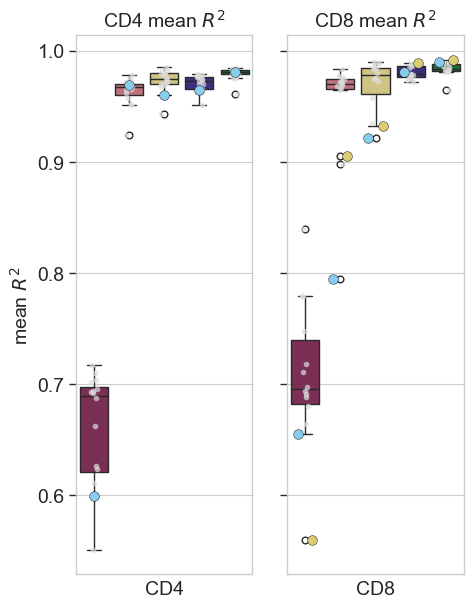

In [14]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = res[(res["subset"]==subset)&(res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", x="", hue="", ax=axes[i], palette=eval_setting_map,
               order=["identity", "avg CAR", "chemCPA", "conCAROT", "within condition"])
    sns.stripplot(data=plt_data[~plt_data["eval_car"].isin(sel_cars)], y="score", x = "", s=4,
                  ax=axes[i], color=default_colors["grey"], dodge=True, legend=False, alpha=0.7)
    sns.stripplot(data=plt_data[plt_data["eval_car"].isin(sel_cars)], y="score", x = "", ax=axes[i], hue="eval_car", s=7, 
                  edgecolor="black", linewidth=0.3, 
                  dodge=True, palette=sc_palette, legend=False)
    axes[i].set_title(f"{subset} mean $R^2$", fontsize=14)
    axes[i].set_ylabel("mean $R^2$", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)
    axes[i].set_xticklabels([])
    axes[i].set_xticks([])
    axes[i].set_xlabel(f"{subset}", fontsize=14)

# axes[0].get_legend().remove()
# axes[1].legend(fontsize=12, loc="lower center")
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_dir}sel_CARs_R2_performance.pdf", bbox_inches="tight")

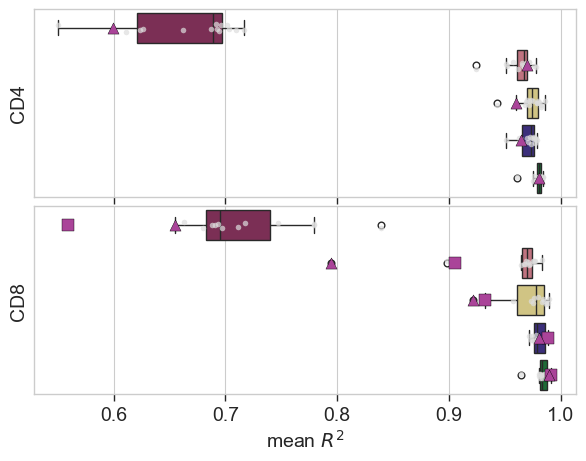

In [15]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,5))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = res[(res["subset"]==subset)&(res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, x="score", y="", hue="", ax=axes[i], palette=eval_setting_map,
               order=["identity", "avg CAR", "chemCPA", "conCAROT", "within condition"])
    sns.stripplot(data=plt_data[~plt_data["eval_car"].isin(sel_cars)], x="score", y="", s=4,
                  ax=axes[i], color=default_colors["grey"], dodge=True, legend=False, alpha=0.7)
    for car in sel_cars:
        sns.stripplot(data=plt_data[plt_data["eval_car"]==car], x="score", y="", ax=axes[i],
                        color=default_colors["purple"],  s=8,  edgecolor="black", marker=sc_markers[car],
                      linewidth=0.3, legend=False)
    axes[i].set_ylabel(f"{subset}", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)
    axes[i].set_yticklabels([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("")

# axes[0].get_legend().remove()
# axes[1].legend(fontsize=12, loc="lower center")
axes[1].set_xlabel("mean $R^2$", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.subplots_adjust(wspace=None, hspace=0.05)
plt.savefig(f"{base_fig_dir}sel_CARs_R2_performance_horizontal.pdf", bbox_inches="tight")

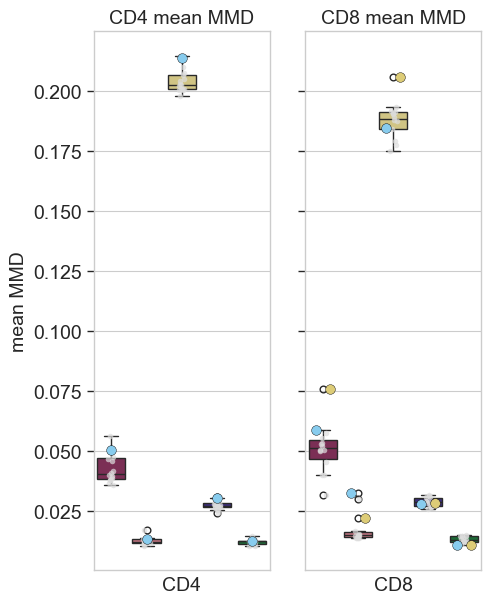

In [16]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = res[(res["subset"]==subset)&(res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, y="score", x="",  hue="", ax=axes[i], palette=eval_setting_map,
               order=["identity", "avg CAR", "chemCPA", "conCAROT", "within condition"])
    sns.stripplot(data=plt_data[~plt_data["eval_car"].isin(sel_cars)], y="score", x = "", s=4,
                  ax=axes[i], color=default_colors["grey"], dodge=True, legend=False, alpha=0.7)
    sns.stripplot(data=plt_data[plt_data["eval_car"].isin(sel_cars)], y="score", x = "", ax=axes[i], hue="eval_car", s=7, 
                  edgecolor="black", linewidth=0.3, 
                  dodge=True, palette=sc_palette, legend=False)
    axes[i].set_title(f"{subset} mean MMD", fontsize=14)
    axes[i].set_ylabel("mean MMD", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)
    axes[i].set_xticklabels([])
    axes[i].set_xticks([])
    axes[i].set_xlabel(f"{subset}", fontsize=14)

# axes[0].get_legend().remove()
# axes[1].legend(fontsize=12, loc="lower center")
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_dir}sel_CARs_MMD_performance.pdf", bbox_inches="tight")

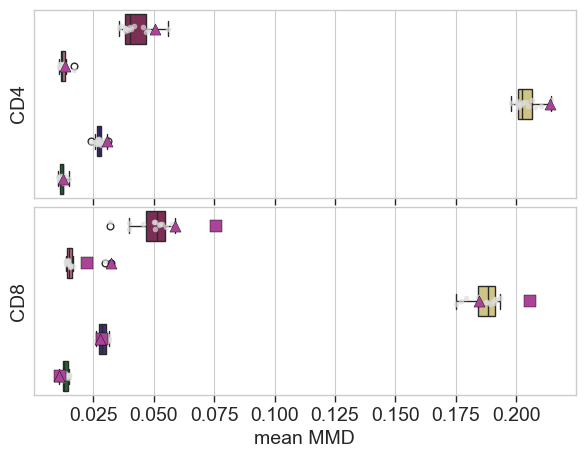

In [17]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,5))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = res[(res["subset"]==subset)&(res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"eval_setting": ""})
    sns.boxplot(data=plt_data, x="score", y="", hue="", ax=axes[i], palette=eval_setting_map,
               order=["identity", "avg CAR", "chemCPA", "conCAROT", "within condition"])
    sns.stripplot(data=plt_data[~plt_data["eval_car"].isin(sel_cars)], x="score", y="", s=4,
                  ax=axes[i], color=default_colors["grey"], dodge=True, legend=False, alpha=0.7)
    for car in sel_cars:
        sns.stripplot(data=plt_data[plt_data["eval_car"]==car], x="score", y="", ax=axes[i],
                        color=default_colors["purple"],  s=8,  edgecolor="black", marker=sc_markers[car],
                      linewidth=0.3, legend=False)
    axes[i].set_ylabel(f"{subset}", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)
    axes[i].set_yticklabels([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("")

# axes[0].get_legend().remove()
# axes[1].legend(fontsize=12, loc="lower center")
axes[1].set_xlabel("mean MMD", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.subplots_adjust(wspace=None, hspace=0.05)
plt.savefig(f"{base_fig_dir}sel_CARs_MMD_performance_horizontal.pdf", bbox_inches="tight")

### Scores per CAR

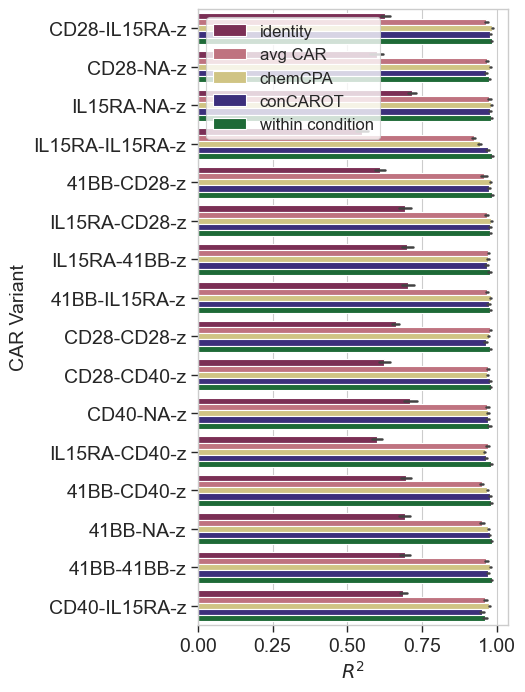

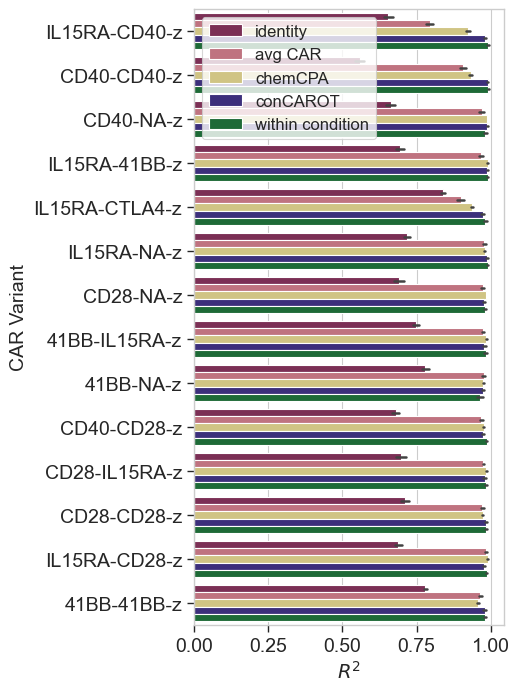

In [18]:
for subset in ["CD4", "CD8"]:
    plt_data = single_scores[(single_scores["subset"]==subset)]
    plt.figure(figsize=(4,8))
    sns.barplot(data=plt_data, x="r2", y="eval_car", hue="eval_setting", palette=eval_setting_map, 
                hue_order=["identity", "avg CAR", "chemCPA", "conCAROT", "within condition"])
    plt.ylabel("CAR Variant", fontsize=14)
    plt.xlabel("$R^2$", fontsize=14)
    plt.tick_params(which="both", axis="both", labelsize=14)
    plt.legend(loc="upper left", title="", fontsize=12)
    plt.savefig(f"{base_fig_dir}sel_CARs_R2_per_car_{subset}.pdf", bbox_inches="tight")
    plt.show()

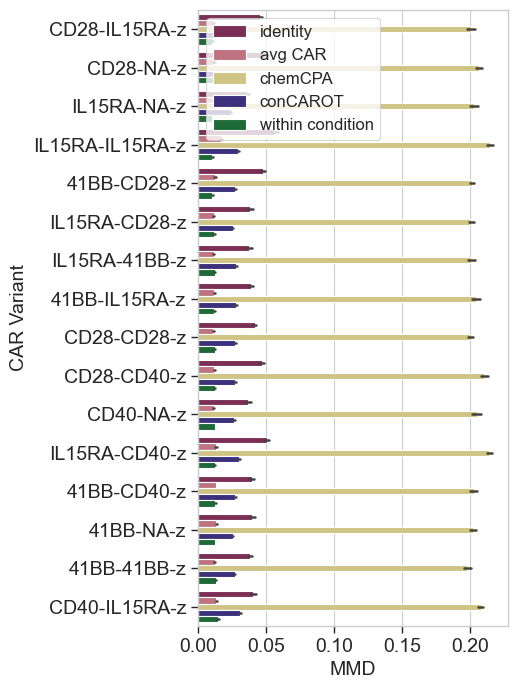

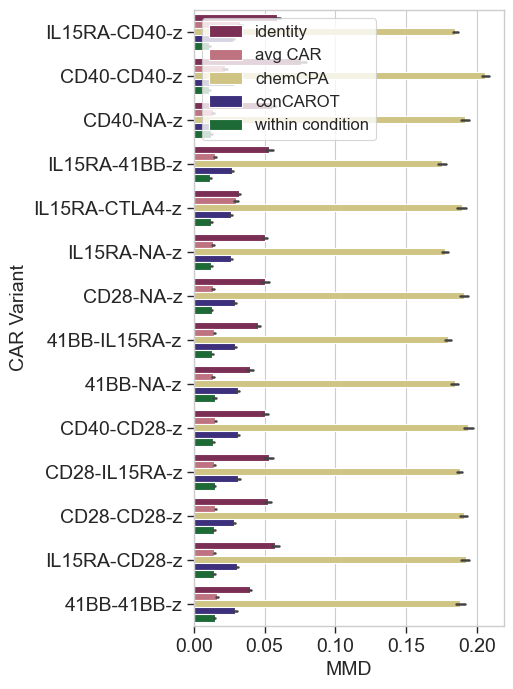

In [19]:
for subset in ["CD4", "CD8"]:
    plt_data = single_scores[(single_scores["subset"]==subset)]
    plt.figure(figsize=(4,8))
    sns.barplot(data=plt_data, x="mmd", y="eval_car", hue="eval_setting", palette=eval_setting_map, 
                hue_order=["identity", "avg CAR", "chemCPA", "conCAROT", "within condition"])
    plt.ylabel("CAR Variant", fontsize=14)
    plt.xlabel("MMD", fontsize=14)
    plt.tick_params(which="both", axis="both", labelsize=14)
    plt.legend(loc="upper left", title="", fontsize=12)
    plt.savefig(f"{base_fig_dir}sel_CARs_MMD_per_car_{subset}.pdf", bbox_inches="tight")
    plt.show()

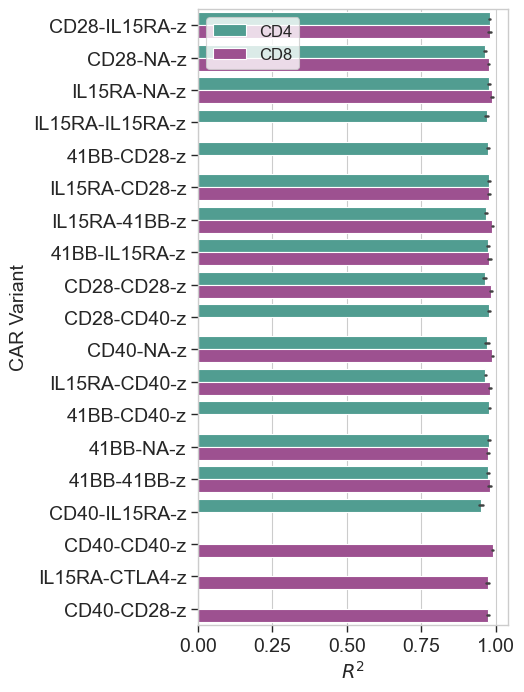

In [20]:
plt_data = single_scores[(single_scores["eval_setting"]=="conCAROT")]
plt.figure(figsize=(4,8))
sns.barplot(data=plt_data, x="r2", y="eval_car", hue="subset", palette=subset_map)
plt.ylabel("CAR Variant", fontsize=14)
plt.xlabel("$R^2$", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.legend(loc="upper left", title="", fontsize=12)
plt.savefig(f"{base_fig_dir}sel_CARs_R2_per_car.pdf", bbox_inches="tight")
plt.show()

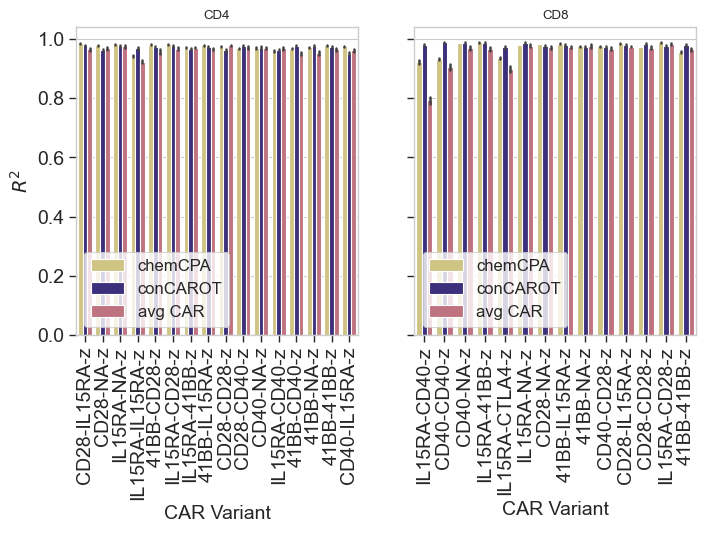

In [21]:
plt_data = single_scores[(single_scores["eval_setting"].isin(["chemCPA", "conCAROT", "avg CAR"]))]
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True)
ax = ax.flatten()
sns.barplot(data=plt_data[plt_data["subset"]=="CD4"], y="r2", x="eval_car", hue="eval_setting", palette=eval_setting_map, ax=ax[0],
           hue_order=["chemCPA", "conCAROT", "avg CAR"])
sns.barplot(data=plt_data[plt_data["subset"]=="CD8"], y="r2", x="eval_car", hue="eval_setting", palette=eval_setting_map, ax=ax[1],
           hue_order=["chemCPA", "conCAROT", "avg CAR"])
ax[0].set_xlabel("CAR Variant", fontsize=14)
ax[0].set_ylabel("$R^2$", fontsize=14)
ax[0].tick_params(which="both", axis="both", labelsize=14)
ax[0].tick_params(axis="x", labelrotation=90)
ax[0].legend(loc="lower left", title="", fontsize=12)
ax[0].set_title("CD4")

ax[1].set_xlabel("CAR Variant", fontsize=14)
ax[1].set_ylabel("$R^2$", fontsize=14)
ax[1].tick_params(which="both", axis="both", labelsize=14)
ax[1].tick_params(axis="x", labelrotation=90)
ax[1].legend(loc="lower left", title="", fontsize=12)
ax[1].set_title("CD8")

plt.savefig(f"{base_fig_dir}sel_CARs_R2_per_car.pdf", bbox_inches="tight")
plt.show()

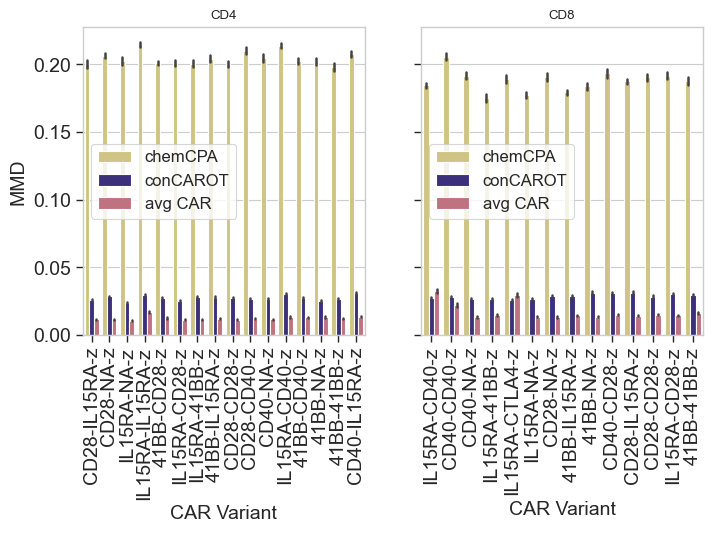

In [22]:
plt_data = single_scores[(single_scores["eval_setting"].isin(["conCAROT", "avg CAR", "chemCPA"]))]
fig, ax = plt.subplots(1, 2, figsize=(8,4), sharey=True)
ax = ax.flatten()
sns.barplot(data=plt_data[plt_data["subset"]=="CD4"], y="mmd", x="eval_car", hue="eval_setting", palette=eval_setting_map, ax=ax[0],
           hue_order=["chemCPA", "conCAROT", "avg CAR"])
sns.barplot(data=plt_data[plt_data["subset"]=="CD8"], y="mmd", x="eval_car", hue="eval_setting", palette=eval_setting_map, ax=ax[1],
           hue_order=["chemCPA", "conCAROT", "avg CAR"])
ax[0].set_xlabel("CAR Variant", fontsize=14)
ax[0].set_ylabel("MMD", fontsize=14)
ax[0].tick_params(which="both", axis="both", labelsize=14)
ax[0].tick_params(axis="x", labelrotation=90)
ax[0].legend(loc="center left", title="", fontsize=12)
ax[0].set_title("CD4")

ax[1].set_xlabel("CAR Variant", fontsize=14)
ax[1].set_ylabel("MMD", fontsize=14)
ax[1].tick_params(which="both", axis="both", labelsize=14)
ax[1].tick_params(axis="x", labelrotation=90)
ax[1].legend(loc="center left", title="", fontsize=12)
ax[1].set_title("CD8")

plt.savefig(f"{base_fig_dir}sel_CARs_MMD_per_car.pdf", bbox_inches="tight")
plt.show()

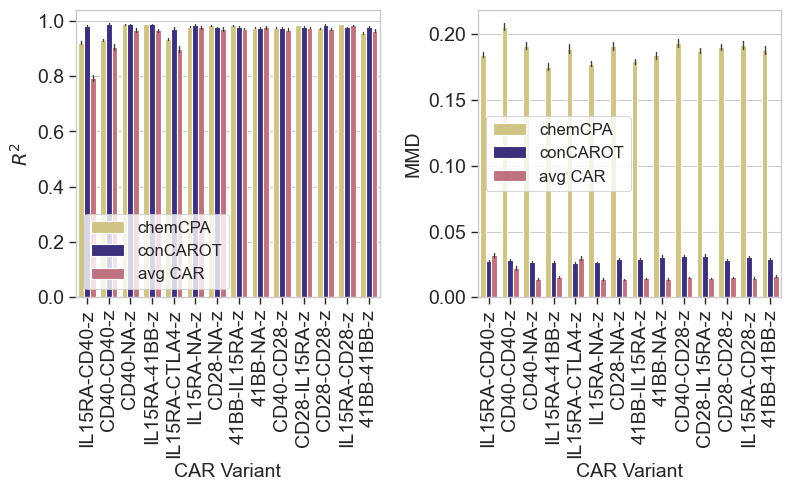

In [29]:
plt_data = single_scores[(single_scores["subset"]=="CD8")&(single_scores["eval_setting"].isin(["conCAROT", "avg CAR", "chemCPA"]))]
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax = ax.flatten()
sns.barplot(data=plt_data, y="r2", x="eval_car", hue="eval_setting", palette=eval_setting_map, ax=ax[0],
           hue_order=["chemCPA", "conCAROT", "avg CAR"], err_kws={"linewidth": 1})
sns.barplot(data=plt_data, y="mmd", x="eval_car", hue="eval_setting", palette=eval_setting_map, ax=ax[1],
           hue_order=["chemCPA", "conCAROT", "avg CAR"], err_kws={"linewidth": 1})
ax[0].set_xlabel("CAR Variant", fontsize=14)
ax[0].set_ylabel("$R^2$", fontsize=14)
ax[0].tick_params(which="both", axis="both", labelsize=14)
ax[0].tick_params(axis="x", labelrotation=90)
ax[0].legend(loc="lower left", title="", fontsize=12)
# ax[0].set_title("")

ax[1].set_xlabel("CAR Variant", fontsize=14)
ax[1].set_ylabel("MMD", fontsize=14)
ax[1].tick_params(which="both", axis="both", labelsize=14)
ax[1].tick_params(axis="x", labelrotation=90)
ax[1].legend(loc="center left", title="", fontsize=12)
# ax[1].set_title("CD8")

fig.tight_layout()

plt.savefig(f"{base_fig_dir}sel_CARs_CD8_mmd_r2.pdf", bbox_inches="tight")
plt.show()

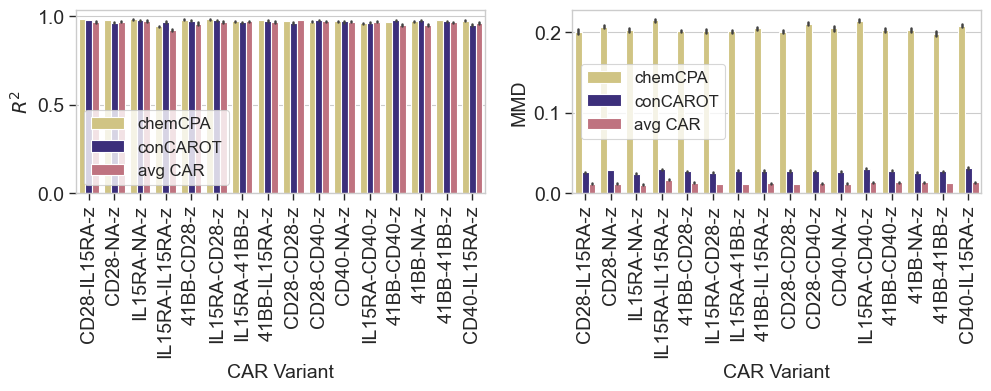

In [24]:
plt_data = single_scores[(single_scores["subset"]=="CD4")&(single_scores["eval_setting"].isin(["conCAROT", "avg CAR", "chemCPA"]))]
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax = ax.flatten()
sns.barplot(data=plt_data, y="r2", x="eval_car", hue="eval_setting", palette=eval_setting_map, ax=ax[0],
           hue_order=["chemCPA", "conCAROT", "avg CAR"])
sns.barplot(data=plt_data, y="mmd", x="eval_car", hue="eval_setting", palette=eval_setting_map, ax=ax[1],
           hue_order=["chemCPA", "conCAROT", "avg CAR"])
ax[0].set_xlabel("CAR Variant", fontsize=14)
ax[0].set_ylabel("$R^2$", fontsize=14)
ax[0].tick_params(which="both", axis="both", labelsize=14)
ax[0].tick_params(axis="x", labelrotation=90)
ax[0].legend(loc="lower left", title="", fontsize=12)
# ax[0].set_title("")

ax[1].set_xlabel("CAR Variant", fontsize=14)
ax[1].set_ylabel("MMD", fontsize=14)
ax[1].tick_params(which="both", axis="both", labelsize=14)
ax[1].tick_params(axis="x", labelrotation=90)
ax[1].legend(loc="center left", title="", fontsize=12)
# ax[1].set_title("CD8")

fig.tight_layout()

plt.savefig(f"{base_fig_dir}sel_CARs_CD4_mmd_r2.pdf", bbox_inches="tight")
plt.show()